# Tutorial 2: Primer to Ponder

<div class="alert alert-block alert-info"> <b>Before we get started: </b> 
    <ul style="list-style-type: none;margin: 0;padding: 0;">
        <li>✍️ To run this notebook, you need to have Ponder installed and set up on your machine. If you have not done so already, please refer to our <a href="https://docs.ponder.io/getting_started/quickstart.html">Quickstart guide</a> to get started.</li>
        <li>📖 Otherwise, if you're just interested in browsing through the tutorial, keep reading below!</li>
    </ul>
</div>

In [1]:
import ponder; ponder.init()
import modin.pandas as pd
import duckdb
duckdb_con = duckdb.connect("../ponder.db")
ponder.configure(default_connection=duckdb_con)

2023-04-21 06:44:41,137 - <module ponder> - WARNING - New version of Ponder is available! `pip install --upgrade ponder` to install!


## What is Ponder?

Ponder lets you run your pandas code directly in your database. This means that you can continue to write pandas, but with the benefits of a database. 

### Key Features

- **Data science at all scales**: With Ponder's technology, the same pandas workflows can be run at all scales, from megabytes to terabytes, without changing a single line of code. Thus benefiting from the [parallelism enabled by DuckDB](https://duckdb.org/why_duckdb.html#duckdbisfast).

- **No change to user workflow:** Data scientists can continue running their existing pandas workflows and writing pandas code in their favorite IDE of choice, and benefit from seamless scalability improvements.
/

- **Simplify your data infrastructure:** No need to set up and maintain compute infrastructure required for other parallel processing frameworks (e.g., Spark, Ray, Dask, etc.) to perform large scale data analysis with pandas. Zero infrastructure management required!

In the following sections, we will showcase some examples of how Ponder works and how it can be used in your work.

### Demo 1: Write SQL no more, Ponder in action!

Under the hood, pandas operations are automatically compiled down to SQL queries that get pushed to DuckDB. Queries are executed directly on DuckDB, with users benefiting from the performance, scalability, and security benefits provided by DuckDB as the computation engine.  

Here is an architecture of how Ponder works: 

<img src="https://ponder.io/wp-content/uploads/2023/04/ponder_architecture.png" width="75%"></img>


To show you that this is actually running in the database, you can enable [query logging on DuckDB](https://duckdb.org/docs/sql/pragmas.html#log_query_path-explain_output-enable_verification-disable_verification-verify_parallelism-disable_verify_parallelism). The pandas operations you execute on Ponder correspond to the SQL queries printed in the log file. 

In [2]:
# Set a path for query logging
duckdb_con.execute("PRAGMA log_query_path='/tmp/duckdb.log';")

In [3]:
df = pd.read_sql("PONDER_BOOKS", duckdb_con)

You can look at the corresponding SQL queries for the pandas operations ran in Ponder by looking at the `/tmp/duckdb.log/` file.

In this case, you can see that as we connected to the table via `pd.read_sql`, this corresponding SQL query was generated: 

In [4]:
cat /tmp/duckdb.log

CREATE TEMP TABLE "Ponder_fowtmokjqj" AS SELECT * , rowid AS _PONDER_ROW_NUMBER_, rowid AS _PONDER_ROW_LABELS_ FROM "PONDER_BOOKS"
SELECT * FROM "Ponder_fowtmokjqj" LIMIT 1
SELECT COUNT(*) FROM ((SELECT "bookID", "title", "authors", "average_rating", "isbn", "isbn13", "language_code", "num_pages", "ratings_count", "text_reviews_count", "publication_date", "publisher", "_PONDER_ROW_NUMBER_", "_PONDER_ROW_LABELS_" FROM "Ponder_hllspmbtbi"));

            SELECT
                "_PONDER_ROW_LABELS_", "bookID", "average_rating", "isbn13", "num_pages", "ratings_count", "text_reviews_count"
            FROM (
                
                    SELECT
                        *
                    FROM (
                        
            SELECT
                "_PONDER_ROW_NUMBER_", "_PONDER_ROW_LABELS_",
                "bookID" / "bookID_ponder_right" AS "bookID", "average_rating" / "average_rating_ponder_right" AS "average_rating", "isbn13" / "isbn13_ponder_right" AS "isbn13", "num_pag

You might recall that in the last tutorial, we performed z-score normalization on all the numerical columns. 

In [5]:
x = df.select_dtypes(include='number').columns
(df[x] - df[x].mean())/df[x].std()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
0,-1.627362,1.814412,0.046412,1.308692,18.469003,10.497845
1,-1.627285,1.586157,0.046411,2.212684,18.979913,11.130456
2,-1.627133,1.386434,0.046412,0.064666,-0.103199,-0.115674
3,-1.627056,1.785880,0.046412,0.408847,20.636974,13.887557
4,-1.626827,2.413581,0.046412,9.759771,0.208758,-0.146723
...,...,...,...,...,...,...
11118,1.857247,0.359287,0.048942,0.728147,-0.158107,-0.202610
11119,1.857400,0.416350,0.045736,1.238197,-0.152533,-0.188638
11120,1.857476,0.073968,0.045736,0.325912,-0.152204,-0.173502
11121,1.857858,-0.610797,0.045557,0.404700,-0.152658,-0.156425


Now take a look at `/tmp/duckdb.log`, the corresponding SQL query is 200+ lines long!!

```sql
SELECT 
  COUNT(*) 
FROM 
  (
    (
      SELECT 
        "bookID", 
        "title", 
        "authors", 
        "average_rating", 
        "isbn", 
        "isbn13", 
        "language_code", 
        "num_pages", 
        "ratings_count", 
        "text_reviews_count", 
        "publication_date", 
        "publisher", 
        "_PONDER_ROW_NUMBER_", 
        "_PONDER_ROW_LABELS_" 
      FROM 
        "Ponder_lfbsbonhti"
    )
  );
SELECT 
  "_PONDER_ROW_LABELS_", 
  "bookID", 
  "average_rating", 
  "isbn13", 
  "num_pages", 
  "ratings_count", 
  "text_reviews_count" 
FROM 
  (
    SELECT 
      * 
    FROM 
      (
        SELECT 
          "_PONDER_ROW_NUMBER_", 
          "_PONDER_ROW_LABELS_", 
          "bookID" / "bookID_ponder_right" AS "bookID", 
          "average_rating" / "average_rating_ponder_right" AS "average_rating", 
          "isbn13" / "isbn13_ponder_right" AS "isbn13", 
          "num_pages" / "num_pages_ponder_right" AS "num_pages", 
          "ratings_count" / "ratings_count_ponder_right" AS "ratings_count", 
          "text_reviews_count" / "text_reviews_count_ponder_right" AS "text_reviews_count" 
        FROM 
          (
            SELECT 
              "_PONDER_ROW_NUMBER_", 
              "_PONDER_ROW_LABELS_", 
              "bookID" - "bookID_ponder_right" AS "bookID", 
              "average_rating" - "average_rating_ponder_right" AS "average_rating", 
              "isbn13" - "isbn13_ponder_right" AS "isbn13", 
              "num_pages" - "num_pages_ponder_right" AS "num_pages", 
              "ratings_count" - "ratings_count_ponder_right" AS "ratings_count", 
              "text_reviews_count" - "text_reviews_count_ponder_right" AS "text_reviews_count" 
            FROM 
              (
                SELECT 
                  "_PONDER_ROW_NUMBER_", 
                  "_PONDER_ROW_LABELS_", 
                  "bookID", 
                  "average_rating", 
                  "isbn13", 
                  "num_pages", 
                  "ratings_count", 
                  "text_reviews_count" 
                FROM 
                  (
                    SELECT 
                      "bookID", 
                      "title", 
                      "authors", 
                      "average_rating", 
                      "isbn", 
                      "isbn13", 
                      "language_code", 
                      "num_pages", 
                      "ratings_count", 
                      "text_reviews_count", 
                      "publication_date", 
                      "publisher", 
                      "_PONDER_ROW_NUMBER_", 
                      "_PONDER_ROW_LABELS_" 
                    FROM 
                      "Ponder_lfbsbonhti"
                  )
              ) AS _PONDER_LEFT_ CROSS 
              JOIN (
                SELECT 
                  "bookID" AS "bookID_ponder_right", 
                  "average_rating" AS "average_rating_ponder_right", 
                  "isbn13" AS "isbn13_ponder_right", 
                  "num_pages" AS "num_pages_ponder_right", 
                  "ratings_count" AS "ratings_count_ponder_right", 
                  "text_reviews_count" AS "text_reviews_count_ponder_right" 
                FROM 
                  (
                    SELECT 
                      MIN(0) AS _PONDER_ROW_NUMBER_, 
                      MIN(0) AS _PONDER_ROW_LABELS_, 
                      AVG("bookID") AS "bookID", 
                      AVG("average_rating") AS "average_rating", 
                      AVG("isbn13") AS "isbn13", 
                      AVG("num_pages") AS "num_pages", 
                      AVG("ratings_count") AS "ratings_count", 
                      AVG("text_reviews_count") AS "text_reviews_count" 
                    FROM 
                      (
                        SELECT 
                          "bookID" :: FLOAT AS "bookID", 
                          "average_rating" :: FLOAT AS "average_rating", 
                          "isbn13" :: FLOAT AS "isbn13", 
                          "num_pages" :: FLOAT AS "num_pages", 
                          "ratings_count" :: FLOAT AS "ratings_count", 
                          "text_reviews_count" :: FLOAT AS "text_reviews_count", 
                          "_PONDER_ROW_LABELS_", 
                          "_PONDER_ROW_NUMBER_" 
                        FROM 
                          (
                            SELECT 
                              "_PONDER_ROW_NUMBER_", 
                              "_PONDER_ROW_LABELS_", 
                              "bookID", 
                              "average_rating", 
                              "isbn13", 
                              "num_pages", 
                              "ratings_count", 
                              "text_reviews_count" 
                            FROM 
                              (
                                SELECT 
                                  "bookID", 
                                  "title", 
                                  "authors", 
                                  "average_rating", 
                                  "isbn", 
                                  "isbn13", 
                                  "language_code", 
                                  "num_pages", 
                                  "ratings_count", 
                                  "text_reviews_count", 
                                  "publication_date", 
                                  "publisher", 
                                  "_PONDER_ROW_NUMBER_", 
                                  "_PONDER_ROW_LABELS_" 
                                FROM 
                                  "Ponder_lfbsbonhti"
                              )
                          )
                      )
                  )
              ) AS _PONDER_RIGHT_
          ) AS _PONDER_LEFT_ CROSS 
          JOIN (
            SELECT 
              "bookID" AS "bookID_ponder_right", 
              "average_rating" AS "average_rating_ponder_right", 
              "isbn13" AS "isbn13_ponder_right", 
              "num_pages" AS "num_pages_ponder_right", 
              "ratings_count" AS "ratings_count_ponder_right", 
              "text_reviews_count" AS "text_reviews_count_ponder_right" 
            FROM 
              (
                SELECT 
                  MIN(0) AS _PONDER_ROW_NUMBER_, 
                  MIN(0) AS _PONDER_ROW_LABELS_, 
                  STDDEV("bookID") AS "bookID", 
                  STDDEV("average_rating") AS "average_rating", 
                  STDDEV("isbn13") AS "isbn13", 
                  STDDEV("num_pages") AS "num_pages", 
                  STDDEV("ratings_count") AS "ratings_count", 
                  STDDEV("text_reviews_count") AS "text_reviews_count" 
                FROM 
                  (
                    SELECT 
                      "_PONDER_ROW_NUMBER_", 
                      "_PONDER_ROW_LABELS_", 
                      "bookID", 
                      "average_rating", 
                      "isbn13", 
                      "num_pages", 
                      "ratings_count", 
                      "text_reviews_count" 
                    FROM 
                      (
                        SELECT 
                          "bookID", 
                          "title", 
                          "authors", 
                          "average_rating", 
                          "isbn", 
                          "isbn13", 
                          "language_code", 
                          "num_pages", 
                          "ratings_count", 
                          "text_reviews_count", 
                          "publication_date", 
                          "publisher", 
                          "_PONDER_ROW_NUMBER_", 
                          "_PONDER_ROW_LABELS_" 
                        FROM 
                          "Ponder_lfbsbonhti"
                      )
                  )
              )
          ) AS _PONDER_RIGHT_
      ) 
    WHERE 
      "_PONDER_ROW_NUMBER_" IN (
        '0', '1', '2', '3', '4', '5', '6', '7', 
        '8', '9', '10', '11', '12', '13', '14', 
        '15', '16', '17', '18', '19', '20', 
        '21', '22', '23', '24', '25', '26', 
        '27', '28', '29', '30', '11092', '11093', 
        '11094', '11095', '11096', '11097', 
        '11098', '11099', '11100', '11101', 
        '11102', '11103', '11104', '11105', 
        '11106', '11107', '11108', '11109', 
        '11110', '11111', '11112', '11113', 
        '11114', '11115', '11116', '11117', 
        '11118', '11119', '11120', '11121', 
        '11122'
      )
  ) 
ORDER BY 
  _PONDER_ROW_NUMBER_ 
LIMIT 
  10001
```

In [6]:
# (Optional) Disable query logging again
duckdb_con.execute("PRAGMA log_query_path='';")

In this example, we saw how something as easy to express in pandas in a single line can in fact take *many* lines of SQL to write. 

Using Ponder leads to huge time-savings since you can think and work natively in pandas when interacting with your data warehouse.

### Demo 2: Scaling Ponder on big data

Ponder is built on our open-source project, [Modin](https://modin.readthedocs.io/en/latest/), which is a faster, more scalable version of pandas. Modin has more than 5M+ downloads to-date and is being adopted in leading data and AI teams. We built Modin and Ponder to address the scalability bottlenecks that practitioners face when using pandas (which is single-threaded and often leads to out-of-memory errors). But unlike other big data frameworks (e.g., Spark, SQL), we let you continue using the same pandas API and semantics, while doing the magic behind the scenes to let you scale on hundreds of GB up to terabytes of data.

In [7]:
import time

In this demo, we perform a series of operations with Ponder and Pandas to compare the performance of working with large datasets. 

First, we load in the CSV file which contains the NYC taxi dataset. The size of this CSV file is 22.6MB. We duplicate this dataset 50 times to create a 15 million row dataset (1.15GB). This is saved as a CSV locally for the performance experiment we'll be doing below.

In [8]:
import pandas
taxi = pandas.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')
bigdf = pandas.concat([taxi for _ in range(50)])
bigdf.to_csv("../taxi_50X.csv",index=None)

Now let's do some timing experiment using Modin and pandas. Let's start with running `read_csv` with Ponder first:

In [9]:
start  = time.time()
df = pd.read_csv("../taxi_50X.csv")
end = time.time()
ponder_op1_duration = end - start

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [21]:
print("Time for read_csv with Ponder: {} seconds".format(round(ponder_op1_duration, 2)))

Time for read_csv with Ponder: 5.68 seconds


Next let's run `isna` with Ponder. (Note that here we are doing `display` on the resulting dataframe, so that the results are printed.)

In [11]:
start  = time.time()
display(df.isna())
end = time.time()
ponder_op2_duration = end - start

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501745,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10501746,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10501747,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10501748,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [22]:
print("Time for isna with Ponder: {} seconds".format(round(ponder_op2_duration, 2)))

Time for isna with Ponder: 0.06 seconds


Let's move onto timing the performance with Pandas now, starting with `read_csv`:

In [13]:
import pandas 

In [14]:
start  = time.time()
pandas_df = pandas.read_csv("../taxi_50X.csv")
end = time.time()
pandas_op1_duration = end - start

In [15]:
print("Time for read_csv with Pandas: {} seconds".format(round(pandas_op1_duration, 2)))

Time for read_csv with Pandas: 7.1 seconds


Next let's run `isna` with pandas: 

In [16]:
start  = time.time()
display(pandas_df.isna())
end = time.time()
pandas_op2_duration = end - start

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,PASSENGER_COUNT,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501745,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10501746,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10501747,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10501748,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [17]:
print("Time for isna with Pandas: {} seconds".format(round(pandas_op2_duration, 2)))

Time for isna with Pandas: 1.94 seconds


In [18]:
# Install matplotlib if you don't already have it
! pip install matplotlib --quiet

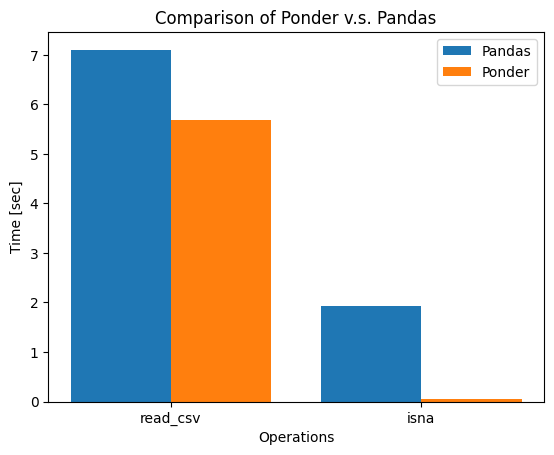

In [19]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['read_csv','isna']
t_pandas = [pandas_op1_duration,pandas_op2_duration]
t_ponder = [ponder_op1_duration,ponder_op2_duration]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, t_pandas, 0.4, label = 'Pandas')
plt.bar(X_axis + 0.2, t_ponder, 0.4, label = 'Ponder')
  
plt.xticks(X_axis, X)
plt.xlabel("Operations")
plt.ylabel("Time [sec]")
plt.title("Comparison of Ponder v.s. Pandas")
plt.legend()
plt.show()

In [20]:
duckdb_con.close()

### Summary

In this tutorial, we saw how Ponder lets you run pandas on DuckDB. 

Demo #1 showed how Ponder simplifies your experience in working with data. It does this by translating your pandas queries to corresponding SQL queries to run on your data warehouse. Ponder gives you the flexibility of working in pandas directly and often there are queries that are easier to write in pandas than having to craft hundreds of lines of SQL!

Demo #2 showed the scale benefits you get from using Ponder in working with large datasets. We saw that Ponder leverages the inherent parallelism of the data warehouse to speed up your pandas queries, leading to runtimes that are much faster than vanilla pandas.

As we can see, there are many benefits from being able to leverage the pandas API (over writing SQL directly) on your data warehouse, as summarized in this table. 

|               | pandas | SQL | Ponder |
|---------------|--------|-----|--------|
| Easy to use   | ✅      | ❌   | ✅      |
| Flexible      | ✅      | ❌   | ✅      |
| Scalable      | ❌      | ✅   | ✅      |
| Secure access | ❌      | ✅   | ✅      |


To learn more about Ponder, check out our product blogpost [here](https://ponder.io/run-pandas-on-1tb-directly-in-your-data-warehouse/).